## Martin Dionne

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import adfuller

# !pip install linearmodels
from linearmodels.panel import PooledOLS
import warnings

# 1. VAR Process

In the data `raotb16.csv` we have some macroeconomic data.

1. Test which series Granger cause each other.

2. Test which series are stationary

3. Fit a VAR on the system of time series. Find the best number of lags. Don't forget to differentiate the series that need it.

4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest your model against the actual last year in the data. Plot the predictions against the data for each series.

In [2]:
# rgnp: Real GNP.
# pgnp: Potential real GNP.
# ulc: Unit labor cost.
# gdfco: Fixed weight deflator for personal consumption expenditure excluding food andenergy.
# gdf: Fixed weight GNP deflator.
# gdfim: Fixed weight import deflator.
# gdfcf: Fixed weight deflator for food in personal consumption expenditure.
# gdfce: Fixed weight deflator for energy in personal consumption expenditure.

In [3]:
df = pd.read_csv('data/raotb16.csv')
df.index = pd.DatetimeIndex(df.date)
df = df.drop(columns=['date'])
data = np.log(df).diff().dropna()

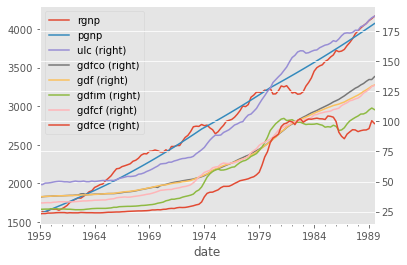

In [4]:
#df.plot(y=['rgnp','pgnp'])
df.plot(secondary_y=['ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce']);

In [5]:
# 1. Test which series Granger cause each other.
model = VAR(data)
results = model.fit(maxlags=12, ic='aic')

var = ['rgnp', 'ulc', 'gdfim', 'gdfcf', 'gdfce']
for v in var:
        vx = var.copy()
        vx.remove(v)
        print(v, ' VS ', vx)
        print(results.test_causality(v, vx, kind='f').summary())

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
rgnp  VS  ['ulc', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: %s do not Granger-cause rgnp. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.9085          1.479   0.639 (48, 104)
-----------------------------------------------
ulc  VS  ['rgnp', 'gdfim', 'gdfcf', 'gdfce']
Granger causality F-test. H_0: %s do not Granger-cause ulc. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.6591          1.479   0.946 (48, 104)
-----------------------------------------------
gdfim  VS  ['rgnp', 'ulc', 'gdfcf', 'gdfce']
Granger causality F-te

In [6]:
# 2. Test which series are stationary
for col in data.columns:
    p = adfuller(data[col], autolag='AIC')[1]
    sta = 'stationary' if p < 0.05 else 'not stationnary' 
    print(f'{col} is {sta} (p-value = {p:.3f})')

rgnp is stationary (p-value = 0.000)
pgnp is not stationnary (p-value = 0.878)
ulc is stationary (p-value = 0.028)
gdfco is not stationnary (p-value = 0.346)
gdf is not stationnary (p-value = 0.407)
gdfim is stationary (p-value = 0.001)
gdfcf is stationary (p-value = 0.003)
gdfce is stationary (p-value = 0.000)


In [7]:
# 3. Fit a VAR on the system of time series. Find the best number of lags.
model = VAR(data[['rgnp', 'ulc', 'gdfim', 'gdfcf', 'gdfce']])
#model.select_order(12)
results = model.fit(maxlags=12, ic='aic')
lag_order = results.k_ar
print(lag_order)
results.summary()

1
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Apr, 2021
Time:                     21:23:37
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -45.3219
Nobs:                     121.000    HQIC:                  -45.7335
Log likelihood:           1955.45    FPE:                1.03775e-20
AIC:                     -46.0151    Det(Omega_mle):     8.14707e-21
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.010512         0.001975            5.323           0.000
L1.rgnp          0.058717         0.111922            0.525           0.600
L1.ulc          -0.284790         0.126098           -2.258           0.024
L1.gd

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


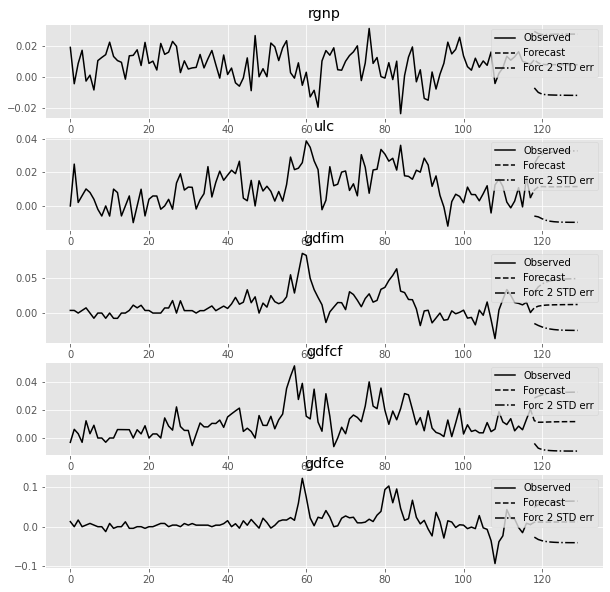

In [8]:
# 4. Fit a VAR on everything except the last 12 months (4 quarters) of the data. Backtest and plot.
train = data[:-4]
model = VAR(train[['rgnp', 'ulc', 'gdfim', 'gdfcf', 'gdfce']])
results = model.fit(maxlags=12, ic='aic')
#results.forecast(data.values[-lag_order:], 5)
results.plot_forecast(12);

# 2. Gun Violence Panel

The [Gun Violence](https://www.kaggle.com/jameslko/gun-violence-data) dataset

1. Transform it into an amenable panel (or structure of multiple time series) to analyze and create a forecast for the next year outside the sample in **Chicago**, **Washington** and **New Orleans**, and the US as a whole.

2. Are there other (non time series) predictors which could be used in this dataset to help predict severity or number of shootings in the future? Analyze the data for feature importance and explain your findings.

In [9]:
def separate(df):
    df=df.split("||")
    df=[(x.split("::")) for x in df]
    y = []
    for  i in range (0, len(df)):
        y.append(df[i][-1])
    return(y) 

In [10]:
gun = pd.read_csv('data/archive.zip', compression='zip')
df = gun[['date','city_or_county', 'n_killed', 'n_injured', 'n_guns_involved']]

df.index = pd.DatetimeIndex(gun.date)
df

,date,city_or_county,n_killed,n_injured,n_guns_involved
date,,,,,
2013-01-01,2013-01-01,Mckeesport,0,4,NaN
2013-01-01,2013-01-01,Hawthorne,1,3,NaN
2013-01-01,2013-01-01,Lorain,1,3,2.0
2013-01-05,2013-01-05,Aurora,4,0,NaN
2013-01-07,2013-01-07,Greensboro,2,2,2.0
...,...,...,...,...,...
2018-03-31,2018-03-31,Rayne,0,0,1.0
2018-03-31,2018-03-31,Natchitoches,1,0,1.0
2018-03-31,2018-03-31,Gretna,0,1,1.0


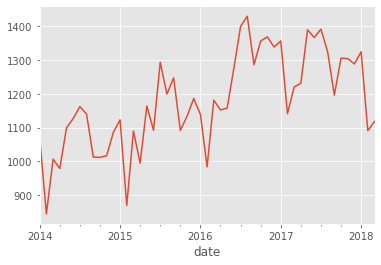

In [11]:
us = df.groupby(df.index.to_period("M")).sum()
#us = df.groupby(df.index).sum()
us = us.loc[us.index >= '2014']
us['n_killed'].plot();

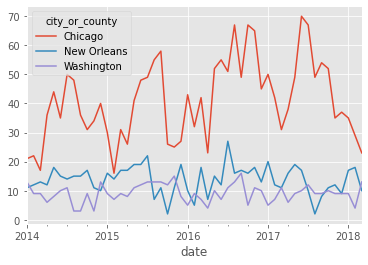

In [12]:
gr = df.where((df['city_or_county'] == 'Chicago') | 
              (df['city_or_county'] == 'Washington') | 
              (df['city_or_county'] == 'New Orleans'))

gr = gr.loc[gr.index >= '2014']
gr = gr.groupby([gr.index.to_period("M"),'city_or_county'] ).sum().unstack()
gr['n_killed'].plot();

In [13]:
#sub = df
sub = df.where((df['city_or_county'] == 'Chicago') | 
               (df['city_or_county'] == 'Washington') | 
               (df['city_or_county'] == 'New Orleans'))

sub = sub.groupby([sub.index.to_period('M'), 'city_or_county']).sum().reset_index()
sub['month'] = pd.Categorical(sub.date)
sub.date = sub.date.astype(str)
sub.date = pd.to_datetime(sub.date)
sub = sub.set_index(['city_or_county', 'date'])
sub

,,n_killed,n_injured,n_guns_involved,month
city_or_county,date,,,,
New Orleans,2013-01-01,0.0,5.0,0.0,2013-01
Washington,2013-01-01,0.0,5.0,1.0,2013-01
Chicago,2013-02-01,0.0,4.0,0.0,2013-02
New Orleans,2013-02-01,0.0,4.0,1.0,2013-02
Chicago,2013-03-01,0.0,7.0,0.0,2013-03
...,...,...,...,...,...
New Orleans,2018-02-01,18.0,30.0,47.0,2018-02
Washington,2018-02-01,4.0,26.0,79.0,2018-02
Chicago,2018-03-01,23.0,142.0,172.0,2018-03


In [14]:
# 1. Transform it into an amenable panel (forecast: Chicago, Washington, N-O, US)
from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import FirstDifferenceOLS

exog_vars = ['n_injured', 'n_guns_involved', 'month']
exog = sm.add_constant(sub[exog_vars])
endog = sub.n_killed

model = PooledOLS(endog, exog)
#model = PanelOLS(endo, exog, entity_effects=True)
#model = FirstDifferenceOLS(endo, exog)  #time-invariant variables must be excluded
pooled_res = model.fit()
print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:               n_killed   R-squared:                        0.9383
Estimator:                  PooledOLS   R-squared (Between):              0.9901
No. Observations:                 169   R-squared (Within):               0.8782
Date:                Mon, Apr 26 2021   R-squared (Overall):              0.9383
Time:                        21:23:51   Log-likelihood                   -481.85
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      26.688
Entities:                           3   P-value                           0.0000
Avg Obs:                       56.333   Distribution:                  F(61,107)
Min Obs:                       55.000                                           
Max Obs:                       58.000   F-statistic (robust):             26.688
                            

In [15]:
sub

,,n_killed,n_injured,n_guns_involved,month
city_or_county,date,,,,
New Orleans,2013-01-01,0.0,5.0,0.0,2013-01
Washington,2013-01-01,0.0,5.0,1.0,2013-01
Chicago,2013-02-01,0.0,4.0,0.0,2013-02
New Orleans,2013-02-01,0.0,4.0,1.0,2013-02
Chicago,2013-03-01,0.0,7.0,0.0,2013-03
...,...,...,...,...,...
New Orleans,2018-02-01,18.0,30.0,47.0,2018-02
Washington,2018-02-01,4.0,26.0,79.0,2018-02
Chicago,2018-03-01,23.0,142.0,172.0,2018-03


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


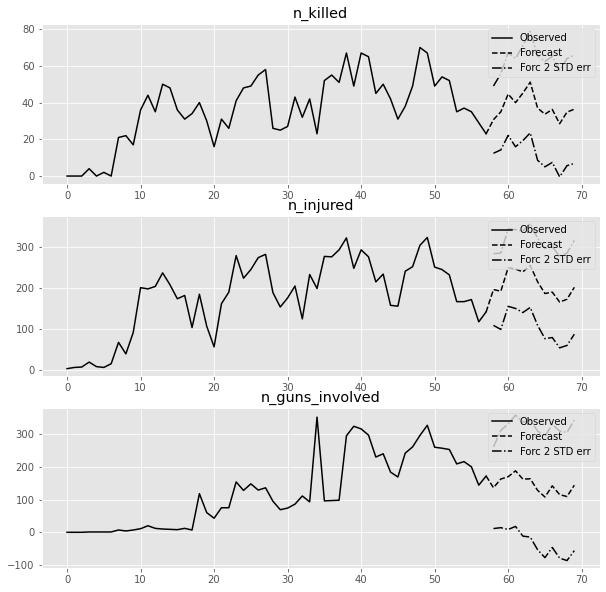

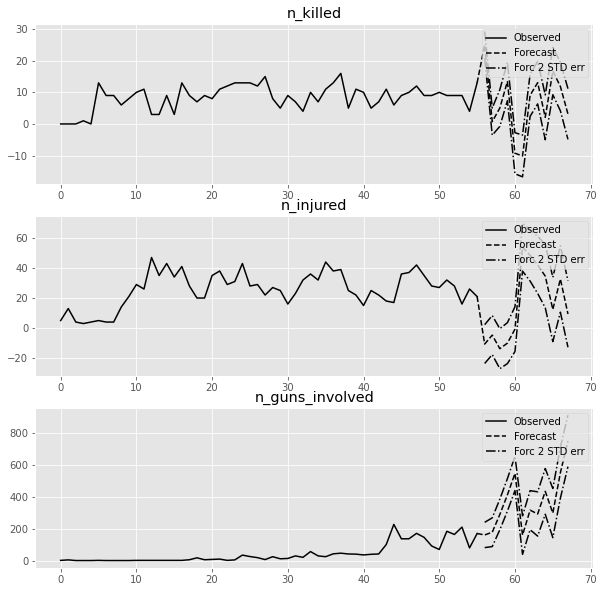

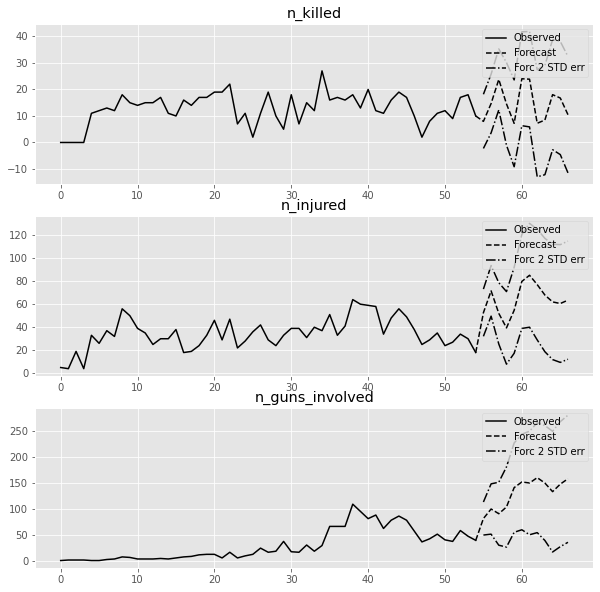

In [17]:
sub = sub.reset_index()
sub.date = pd.DatetimeIndex(sub.date)
cities = ['Chicago', 'Washington', 'New Orleans']

for c in cities:
    #print('------', c ,'------')
    #city = sub.loc[(sub.city_or_county == c) & (sub.date >= '2014')].groupby("date").sum()
    city = sub.loc[(sub.city_or_county == c)].groupby("date").sum()
    city = city[['n_killed', 'n_injured', 'n_guns_involved']]
    #print(city)
    model = VAR(city)
    results = model.fit(maxlags=12, ic='aic')
    #results.summary()
    results.plot_forecast(12);

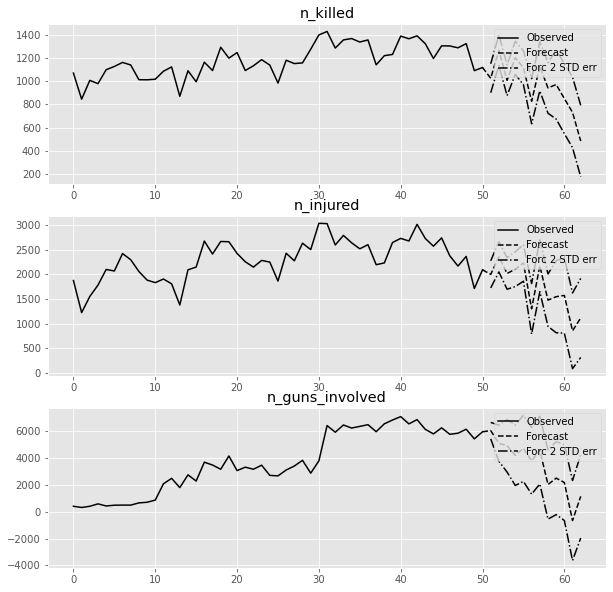

In [18]:
us 
model = VAR(us)
results = model.fit(maxlags=12, ic='aic')
#results.summary()
results.plot_forecast(12);

In [19]:
# 2. Are there other (non time series) predictors which could be used 

# All predictors are all "after the fact data" which means they are more consequences than predictors 
# except latitute and longitude which might give away "violence prone" areas 